# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [11]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    isTraining = tf.placeholder(tf.bool, [], name='isTraining')
    return actions, states, targetQs, isTraining

In [12]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [13]:
def actor_target(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor_target', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [14]:
def model_loss(actions, states, targetQs, action_size, hidden_size, isTraining):
    actions_target = actor_target(states=states, hidden_size=hidden_size, action_size=action_size, 
                                  training=isTraining)
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size, training=isTraining)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_target, loss

In [22]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars_tgt = [var for var in t_vars if var.name.startswith('actor_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)
        
    opt_tgt = [g_vars_tgt[idx].assign((g_vars_tgt[idx]*gamma) + (g_vars[idx]*(1-gamma))) 
               for idx in range(len(g_vars_tgt))]
    
    return opt, opt_tgt

In [23]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.isTraining = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, isTraining=self.isTraining)

        # Update the model: backward pass and backprop
        self.opt, self.opt_tgt = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=gamma)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [24]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [25]:
env.observation_space, env.action_space, \
env.observation_space.low, env.observation_space.high, \
env.action_space.n

(Box(4,),
 Discrete(2),
 array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32),
 2)

In [26]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 32                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [27]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
              gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [28]:
state = env.reset()

for _ in range(memory_size):
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    n_episodes = 100000000
    
    # Training episodes/epochs
    for ep in range(n_episodes):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.isTraining: False})
                action = np.argmax(action_logits)
                
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # minibatch
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # targetQs
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states, 
                                                                              model.isTraining: False})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)

            # train
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs, 
                                                                     model.isTraining: True})
            loss_batch.append(loss)
            
            # Train target network
            sess.run(model.opt_tgt)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:12.0000 R:12.0 loss:0.5346 exploreP:0.9988
Episode:1 meanR:10.5000 R:9.0 loss:0.5250 exploreP:0.9979
Episode:2 meanR:21.0000 R:42.0 loss:0.5074 exploreP:0.9938
Episode:3 meanR:24.2500 R:34.0 loss:0.4613 exploreP:0.9904
Episode:4 meanR:22.2000 R:14.0 loss:0.4486 exploreP:0.9891
Episode:5 meanR:21.0000 R:15.0 loss:0.4497 exploreP:0.9876
Episode:6 meanR:20.0000 R:14.0 loss:0.4218 exploreP:0.9862
Episode:7 meanR:21.0000 R:28.0 loss:0.3719 exploreP:0.9835
Episode:8 meanR:20.0000 R:12.0 loss:0.3012 exploreP:0.9823
Episode:9 meanR:20.4000 R:24.0 loss:0.2742 exploreP:0.9800
Episode:10 meanR:19.9091 R:15.0 loss:0.2127 exploreP:0.9786
Episode:11 meanR:21.0833 R:34.0 loss:0.1814 exploreP:0.9753
Episode:12 meanR:21.2308 R:23.0 loss:0.1753 exploreP:0.9730
Episode:13 meanR:20.7857 R:15.0 loss:0.1529 exploreP:0.9716
Episode:14 meanR:20.3333 R:14.0 loss:0.1394 exploreP:0.9703
Episode:15 meanR:21.2500 R:35.0 loss:0.1079 exploreP:0.9669
Episode:16 meanR:20.8235 R:14.0 loss:0.0981 explore

Episode:137 meanR:22.1300 R:17.0 loss:0.1017 exploreP:0.7415
Episode:138 meanR:22.0400 R:10.0 loss:0.1141 exploreP:0.7408
Episode:139 meanR:22.0300 R:15.0 loss:0.0806 exploreP:0.7397
Episode:140 meanR:22.0800 R:20.0 loss:0.1182 exploreP:0.7382
Episode:141 meanR:22.0200 R:10.0 loss:0.1059 exploreP:0.7375
Episode:142 meanR:22.0900 R:19.0 loss:0.1186 exploreP:0.7361
Episode:143 meanR:22.1500 R:25.0 loss:0.1028 exploreP:0.7343
Episode:144 meanR:21.7800 R:15.0 loss:0.0962 exploreP:0.7332
Episode:145 meanR:21.8200 R:27.0 loss:0.0871 exploreP:0.7313
Episode:146 meanR:21.8200 R:20.0 loss:0.0817 exploreP:0.7298
Episode:147 meanR:21.7400 R:18.0 loss:0.0974 exploreP:0.7285
Episode:148 meanR:21.6900 R:14.0 loss:0.0884 exploreP:0.7275
Episode:149 meanR:21.5600 R:16.0 loss:0.0881 exploreP:0.7264
Episode:150 meanR:21.8600 R:48.0 loss:0.1155 exploreP:0.7229
Episode:151 meanR:21.8000 R:10.0 loss:0.2407 exploreP:0.7222
Episode:152 meanR:21.8100 R:19.0 loss:0.0942 exploreP:0.7209
Episode:153 meanR:21.730

Episode:272 meanR:21.1400 R:20.0 loss:0.1010 exploreP:0.5615
Episode:273 meanR:21.0000 R:13.0 loss:0.0866 exploreP:0.5608
Episode:274 meanR:21.1100 R:24.0 loss:0.0976 exploreP:0.5594
Episode:275 meanR:21.0900 R:9.0 loss:0.0891 exploreP:0.5589
Episode:276 meanR:21.0500 R:18.0 loss:0.0948 exploreP:0.5580
Episode:277 meanR:21.0000 R:12.0 loss:0.0802 exploreP:0.5573
Episode:278 meanR:20.9400 R:14.0 loss:0.0889 exploreP:0.5565
Episode:279 meanR:20.8600 R:11.0 loss:0.1441 exploreP:0.5559
Episode:280 meanR:20.6000 R:15.0 loss:0.0722 exploreP:0.5551
Episode:281 meanR:20.5100 R:16.0 loss:0.1110 exploreP:0.5542
Episode:282 meanR:20.5400 R:13.0 loss:0.1124 exploreP:0.5535
Episode:283 meanR:20.3400 R:13.0 loss:0.0825 exploreP:0.5528
Episode:284 meanR:20.4500 R:20.0 loss:0.1039 exploreP:0.5518
Episode:285 meanR:20.3800 R:9.0 loss:0.0900 exploreP:0.5513
Episode:286 meanR:20.4000 R:22.0 loss:0.1011 exploreP:0.5501
Episode:287 meanR:20.3900 R:30.0 loss:0.0860 exploreP:0.5485
Episode:288 meanR:20.4100 

Episode:408 meanR:19.3400 R:22.0 loss:0.1245 exploreP:0.4356
Episode:409 meanR:19.1700 R:9.0 loss:0.0918 exploreP:0.4353
Episode:410 meanR:18.9400 R:9.0 loss:0.0817 exploreP:0.4349
Episode:411 meanR:18.8000 R:13.0 loss:0.0739 exploreP:0.4343
Episode:412 meanR:18.7600 R:13.0 loss:0.0950 exploreP:0.4338
Episode:413 meanR:18.6600 R:10.0 loss:0.0859 exploreP:0.4334
Episode:414 meanR:18.6300 R:13.0 loss:0.0780 exploreP:0.4328
Episode:415 meanR:18.6100 R:16.0 loss:0.0896 exploreP:0.4321
Episode:416 meanR:18.6200 R:14.0 loss:0.0839 exploreP:0.4315
Episode:417 meanR:18.7400 R:35.0 loss:0.0875 exploreP:0.4301
Episode:418 meanR:18.9100 R:27.0 loss:0.1055 exploreP:0.4289
Episode:419 meanR:18.9100 R:10.0 loss:0.0695 exploreP:0.4285
Episode:420 meanR:18.8700 R:14.0 loss:0.1185 exploreP:0.4279
Episode:421 meanR:19.2300 R:55.0 loss:0.0803 exploreP:0.4256
Episode:422 meanR:19.3800 R:26.0 loss:0.0793 exploreP:0.4246
Episode:423 meanR:19.4200 R:19.0 loss:0.0856 exploreP:0.4238
Episode:424 meanR:19.2400 

Episode:543 meanR:18.6900 R:18.0 loss:0.0957 exploreP:0.3369
Episode:544 meanR:18.3800 R:12.0 loss:0.0811 exploreP:0.3365
Episode:545 meanR:18.4000 R:14.0 loss:0.0830 exploreP:0.3360
Episode:546 meanR:18.4200 R:26.0 loss:0.0800 exploreP:0.3352
Episode:547 meanR:18.4400 R:29.0 loss:0.0799 exploreP:0.3342
Episode:548 meanR:18.4600 R:15.0 loss:0.1154 exploreP:0.3338
Episode:549 meanR:18.4500 R:10.0 loss:0.0707 exploreP:0.3334
Episode:550 meanR:19.1200 R:84.0 loss:0.0893 exploreP:0.3307
Episode:551 meanR:19.4600 R:46.0 loss:0.0795 exploreP:0.3293
Episode:552 meanR:19.1700 R:8.0 loss:0.0792 exploreP:0.3290
Episode:553 meanR:19.6800 R:68.0 loss:0.0939 exploreP:0.3268
Episode:554 meanR:19.9600 R:43.0 loss:0.0836 exploreP:0.3255
Episode:555 meanR:19.8600 R:12.0 loss:0.0850 exploreP:0.3251
Episode:556 meanR:19.9100 R:15.0 loss:0.1094 exploreP:0.3246
Episode:557 meanR:19.4700 R:10.0 loss:0.0851 exploreP:0.3243
Episode:558 meanR:19.5400 R:18.0 loss:0.0976 exploreP:0.3238
Episode:559 meanR:19.7200

Episode:679 meanR:20.1900 R:11.0 loss:0.1176 exploreP:0.2563
Episode:680 meanR:20.1400 R:21.0 loss:0.0896 exploreP:0.2558
Episode:681 meanR:20.1500 R:11.0 loss:0.0812 exploreP:0.2556
Episode:682 meanR:20.3500 R:36.0 loss:0.0962 exploreP:0.2547
Episode:683 meanR:20.1800 R:12.0 loss:0.1014 exploreP:0.2544
Episode:684 meanR:20.2500 R:33.0 loss:0.0842 exploreP:0.2536
Episode:685 meanR:19.5900 R:11.0 loss:0.1545 exploreP:0.2533
Episode:686 meanR:19.3700 R:10.0 loss:0.1088 exploreP:0.2531
Episode:687 meanR:19.3900 R:11.0 loss:0.0918 exploreP:0.2528
Episode:688 meanR:19.2500 R:11.0 loss:0.0795 exploreP:0.2525
Episode:689 meanR:19.0200 R:9.0 loss:0.0675 exploreP:0.2523
Episode:690 meanR:19.1500 R:27.0 loss:0.0993 exploreP:0.2517
Episode:691 meanR:18.9200 R:12.0 loss:0.0921 exploreP:0.2514
Episode:692 meanR:18.9800 R:30.0 loss:0.0819 exploreP:0.2506
Episode:693 meanR:19.2900 R:41.0 loss:0.0876 exploreP:0.2497
Episode:694 meanR:19.3400 R:20.0 loss:0.0904 exploreP:0.2492
Episode:695 meanR:19.2400

Episode:816 meanR:17.4100 R:12.0 loss:0.0717 exploreP:0.2047
Episode:817 meanR:17.1800 R:11.0 loss:0.0827 exploreP:0.2045
Episode:818 meanR:17.1300 R:13.0 loss:0.0874 exploreP:0.2042
Episode:819 meanR:16.8200 R:9.0 loss:0.0898 exploreP:0.2041
Episode:820 meanR:16.8100 R:11.0 loss:0.0777 exploreP:0.2039
Episode:821 meanR:16.8000 R:10.0 loss:0.0794 exploreP:0.2037
Episode:822 meanR:16.8700 R:37.0 loss:0.1002 exploreP:0.2029
Episode:823 meanR:16.7600 R:12.0 loss:0.0776 exploreP:0.2027
Episode:824 meanR:16.5300 R:12.0 loss:0.0927 exploreP:0.2025
Episode:825 meanR:16.5300 R:10.0 loss:0.1781 exploreP:0.2023
Episode:826 meanR:16.6900 R:25.0 loss:0.1442 exploreP:0.2018
Episode:827 meanR:16.2000 R:22.0 loss:0.0944 exploreP:0.2014
Episode:828 meanR:16.2200 R:11.0 loss:0.1134 exploreP:0.2012
Episode:829 meanR:16.2100 R:9.0 loss:0.0783 exploreP:0.2010
Episode:830 meanR:16.3600 R:25.0 loss:0.1138 exploreP:0.2005
Episode:831 meanR:16.4300 R:16.0 loss:0.0859 exploreP:0.2002
Episode:832 meanR:16.3400 

Episode:951 meanR:17.2600 R:9.0 loss:0.0588 exploreP:0.1649
Episode:952 meanR:17.3200 R:17.0 loss:0.0738 exploreP:0.1646
Episode:953 meanR:17.2900 R:11.0 loss:0.0785 exploreP:0.1645
Episode:954 meanR:17.3000 R:11.0 loss:0.0630 exploreP:0.1643
Episode:955 meanR:17.2900 R:10.0 loss:0.0742 exploreP:0.1641
Episode:956 meanR:17.4200 R:23.0 loss:0.0724 exploreP:0.1638
Episode:957 meanR:17.4100 R:8.0 loss:0.0817 exploreP:0.1637
Episode:958 meanR:17.5500 R:25.0 loss:0.0830 exploreP:0.1633
Episode:959 meanR:17.6300 R:20.0 loss:0.0822 exploreP:0.1630
Episode:960 meanR:17.5500 R:16.0 loss:0.0827 exploreP:0.1627
Episode:961 meanR:17.6200 R:21.0 loss:0.0664 exploreP:0.1624
Episode:962 meanR:17.6100 R:10.0 loss:0.0750 exploreP:0.1622
Episode:963 meanR:17.6600 R:16.0 loss:0.0856 exploreP:0.1620
Episode:964 meanR:17.8900 R:34.0 loss:0.0948 exploreP:0.1615
Episode:965 meanR:17.9400 R:27.0 loss:0.0968 exploreP:0.1611
Episode:966 meanR:17.9500 R:10.0 loss:0.0773 exploreP:0.1609
Episode:967 meanR:17.8200 

Episode:1087 meanR:17.3900 R:22.0 loss:0.0883 exploreP:0.1314
Episode:1088 meanR:17.4500 R:16.0 loss:0.0661 exploreP:0.1312
Episode:1089 meanR:17.4500 R:9.0 loss:0.0565 exploreP:0.1311
Episode:1090 meanR:17.4600 R:10.0 loss:0.1112 exploreP:0.1310
Episode:1091 meanR:17.5600 R:23.0 loss:0.0731 exploreP:0.1307
Episode:1092 meanR:17.3800 R:8.0 loss:0.0797 exploreP:0.1306
Episode:1093 meanR:17.1500 R:11.0 loss:0.0674 exploreP:0.1305
Episode:1094 meanR:17.1100 R:11.0 loss:0.0712 exploreP:0.1303
Episode:1095 meanR:17.0300 R:30.0 loss:0.0919 exploreP:0.1300
Episode:1096 meanR:16.9700 R:10.0 loss:0.0848 exploreP:0.1299
Episode:1097 meanR:16.9800 R:13.0 loss:0.0759 exploreP:0.1297
Episode:1098 meanR:16.7600 R:10.0 loss:0.0691 exploreP:0.1296
Episode:1099 meanR:16.7700 R:10.0 loss:0.0884 exploreP:0.1295
Episode:1100 meanR:16.8700 R:22.0 loss:0.0853 exploreP:0.1292
Episode:1101 meanR:16.8700 R:9.0 loss:0.0630 exploreP:0.1291
Episode:1102 meanR:16.8000 R:25.0 loss:0.0725 exploreP:0.1288
Episode:110

Episode:1220 meanR:15.2000 R:11.0 loss:0.0760 exploreP:0.1091
Episode:1221 meanR:15.3500 R:27.0 loss:0.0933 exploreP:0.1088
Episode:1222 meanR:15.3700 R:12.0 loss:0.0680 exploreP:0.1087
Episode:1223 meanR:15.3700 R:10.0 loss:0.1353 exploreP:0.1086
Episode:1224 meanR:15.3800 R:15.0 loss:0.0809 exploreP:0.1084
Episode:1225 meanR:15.3500 R:21.0 loss:0.0609 exploreP:0.1082
Episode:1226 meanR:15.3200 R:10.0 loss:0.0585 exploreP:0.1081
Episode:1227 meanR:15.4100 R:26.0 loss:0.0678 exploreP:0.1079
Episode:1228 meanR:15.4000 R:11.0 loss:0.1211 exploreP:0.1078
Episode:1229 meanR:15.4000 R:10.0 loss:0.0534 exploreP:0.1077
Episode:1230 meanR:15.1000 R:12.0 loss:0.0696 exploreP:0.1076
Episode:1231 meanR:15.1100 R:10.0 loss:0.0749 exploreP:0.1075
Episode:1232 meanR:14.8800 R:10.0 loss:0.0675 exploreP:0.1074
Episode:1233 meanR:14.9100 R:19.0 loss:0.0770 exploreP:0.1072
Episode:1234 meanR:15.0400 R:25.0 loss:0.0714 exploreP:0.1069
Episode:1235 meanR:15.0200 R:10.0 loss:0.0547 exploreP:0.1068
Episode:

Episode:1354 meanR:17.3500 R:18.0 loss:0.0749 exploreP:0.0887
Episode:1355 meanR:17.3900 R:26.0 loss:0.0910 exploreP:0.0885
Episode:1356 meanR:17.6600 R:38.0 loss:0.0837 exploreP:0.0882
Episode:1357 meanR:17.6400 R:11.0 loss:0.0676 exploreP:0.0881
Episode:1358 meanR:17.5500 R:19.0 loss:0.1263 exploreP:0.0879
Episode:1359 meanR:17.5600 R:10.0 loss:0.0745 exploreP:0.0878
Episode:1360 meanR:17.5100 R:27.0 loss:0.0764 exploreP:0.0876
Episode:1361 meanR:17.5600 R:14.0 loss:0.0934 exploreP:0.0875
Episode:1362 meanR:17.5600 R:10.0 loss:0.0481 exploreP:0.0874
Episode:1363 meanR:17.5800 R:14.0 loss:0.0633 exploreP:0.0873
Episode:1364 meanR:17.3500 R:10.0 loss:0.0890 exploreP:0.0873
Episode:1365 meanR:17.4900 R:23.0 loss:0.0847 exploreP:0.0871
Episode:1366 meanR:17.2500 R:24.0 loss:0.0862 exploreP:0.0869
Episode:1367 meanR:17.4200 R:29.0 loss:0.0719 exploreP:0.0867
Episode:1368 meanR:17.4800 R:16.0 loss:0.0727 exploreP:0.0866
Episode:1369 meanR:17.4200 R:10.0 loss:0.0981 exploreP:0.0865
Episode:

Episode:1489 meanR:16.7500 R:10.0 loss:0.1059 exploreP:0.0725
Episode:1490 meanR:16.8200 R:17.0 loss:0.0600 exploreP:0.0723
Episode:1491 meanR:16.8200 R:12.0 loss:0.0696 exploreP:0.0723
Episode:1492 meanR:16.8000 R:8.0 loss:0.0619 exploreP:0.0722
Episode:1493 meanR:16.8300 R:13.0 loss:0.0687 exploreP:0.0721
Episode:1494 meanR:16.8400 R:11.0 loss:0.0827 exploreP:0.0721
Episode:1495 meanR:16.8600 R:11.0 loss:0.0764 exploreP:0.0720
Episode:1496 meanR:16.6400 R:10.0 loss:0.0453 exploreP:0.0719
Episode:1497 meanR:16.7000 R:18.0 loss:0.1251 exploreP:0.0718
Episode:1498 meanR:16.8500 R:25.0 loss:0.0631 exploreP:0.0717
Episode:1499 meanR:16.6800 R:10.0 loss:0.0599 exploreP:0.0716
Episode:1500 meanR:16.7100 R:12.0 loss:0.0594 exploreP:0.0715
Episode:1501 meanR:16.9300 R:32.0 loss:0.0811 exploreP:0.0713
Episode:1502 meanR:17.1300 R:30.0 loss:0.0754 exploreP:0.0712
Episode:1503 meanR:17.0800 R:12.0 loss:0.0947 exploreP:0.0711
Episode:1504 meanR:17.0600 R:9.0 loss:0.0744 exploreP:0.0710
Episode:15

Episode:1622 meanR:15.4700 R:34.0 loss:0.0705 exploreP:0.0608
Episode:1623 meanR:15.4600 R:10.0 loss:0.0889 exploreP:0.0608
Episode:1624 meanR:15.6100 R:24.0 loss:0.0662 exploreP:0.0607
Episode:1625 meanR:15.4300 R:9.0 loss:0.0800 exploreP:0.0606
Episode:1626 meanR:15.6100 R:27.0 loss:0.0650 exploreP:0.0605
Episode:1627 meanR:15.4000 R:10.0 loss:0.0702 exploreP:0.0604
Episode:1628 meanR:15.0200 R:9.0 loss:0.0799 exploreP:0.0604
Episode:1629 meanR:15.0200 R:10.0 loss:0.0657 exploreP:0.0603
Episode:1630 meanR:15.0000 R:10.0 loss:0.0843 exploreP:0.0603
Episode:1631 meanR:14.8500 R:9.0 loss:0.0820 exploreP:0.0602
Episode:1632 meanR:15.0800 R:34.0 loss:0.0758 exploreP:0.0601
Episode:1633 meanR:15.1400 R:15.0 loss:0.0798 exploreP:0.0600
Episode:1634 meanR:15.2700 R:37.0 loss:0.0715 exploreP:0.0598
Episode:1635 meanR:15.2700 R:11.0 loss:0.0846 exploreP:0.0597
Episode:1636 meanR:15.2800 R:12.0 loss:0.0570 exploreP:0.0597
Episode:1637 meanR:15.2800 R:9.0 loss:0.0873 exploreP:0.0596
Episode:1638

Episode:1755 meanR:16.6700 R:30.0 loss:0.0802 exploreP:0.0511
Episode:1756 meanR:16.5200 R:9.0 loss:0.0611 exploreP:0.0510
Episode:1757 meanR:16.3400 R:12.0 loss:0.0544 exploreP:0.0510
Episode:1758 meanR:16.2300 R:11.0 loss:0.0429 exploreP:0.0510
Episode:1759 meanR:16.3900 R:25.0 loss:0.0657 exploreP:0.0508
Episode:1760 meanR:16.2600 R:15.0 loss:0.0857 exploreP:0.0508
Episode:1761 meanR:16.2900 R:25.0 loss:0.0751 exploreP:0.0507
Episode:1762 meanR:16.3200 R:13.0 loss:0.0534 exploreP:0.0506
Episode:1763 meanR:16.5000 R:28.0 loss:0.0850 exploreP:0.0505
Episode:1764 meanR:16.4200 R:26.0 loss:0.0837 exploreP:0.0504
Episode:1765 meanR:16.4100 R:11.0 loss:0.0634 exploreP:0.0504
Episode:1766 meanR:16.5500 R:24.0 loss:0.0602 exploreP:0.0503
Episode:1767 meanR:16.5700 R:12.0 loss:0.0687 exploreP:0.0502
Episode:1768 meanR:16.5700 R:10.0 loss:0.0604 exploreP:0.0502
Episode:1769 meanR:16.5600 R:12.0 loss:0.0639 exploreP:0.0501
Episode:1770 meanR:16.5000 R:10.0 loss:0.0884 exploreP:0.0501
Episode:1

Episode:1890 meanR:14.7700 R:10.0 loss:0.0592 exploreP:0.0435
Episode:1891 meanR:15.0900 R:43.0 loss:0.0673 exploreP:0.0433
Episode:1892 meanR:15.0800 R:24.0 loss:0.0870 exploreP:0.0433
Episode:1893 meanR:15.0500 R:13.0 loss:0.0570 exploreP:0.0432
Episode:1894 meanR:15.0000 R:12.0 loss:0.0818 exploreP:0.0432
Episode:1895 meanR:14.9300 R:14.0 loss:0.1051 exploreP:0.0431
Episode:1896 meanR:14.9300 R:10.0 loss:0.0462 exploreP:0.0431
Episode:1897 meanR:14.9400 R:10.0 loss:0.1048 exploreP:0.0431
Episode:1898 meanR:15.0300 R:19.0 loss:0.0845 exploreP:0.0430
Episode:1899 meanR:14.8900 R:12.0 loss:0.0689 exploreP:0.0430
Episode:1900 meanR:14.9000 R:10.0 loss:0.0601 exploreP:0.0429
Episode:1901 meanR:14.9000 R:9.0 loss:0.0799 exploreP:0.0429
Episode:1902 meanR:14.6800 R:9.0 loss:0.0494 exploreP:0.0429
Episode:1903 meanR:14.8700 R:28.0 loss:0.0638 exploreP:0.0428
Episode:1904 meanR:14.8600 R:9.0 loss:0.0597 exploreP:0.0427
Episode:1905 meanR:14.8900 R:13.0 loss:0.1162 exploreP:0.0427
Episode:190

Episode:2025 meanR:15.9700 R:9.0 loss:0.0665 exploreP:0.0370
Episode:2026 meanR:15.8000 R:12.0 loss:0.0744 exploreP:0.0370
Episode:2027 meanR:15.7800 R:11.0 loss:0.0709 exploreP:0.0369
Episode:2028 meanR:15.5600 R:9.0 loss:0.0704 exploreP:0.0369
Episode:2029 meanR:15.5300 R:12.0 loss:0.0774 exploreP:0.0369
Episode:2030 meanR:15.5500 R:11.0 loss:0.0583 exploreP:0.0369
Episode:2031 meanR:15.5200 R:10.0 loss:0.0578 exploreP:0.0368
Episode:2032 meanR:15.4300 R:10.0 loss:0.0602 exploreP:0.0368
Episode:2033 meanR:15.3200 R:10.0 loss:0.0492 exploreP:0.0368
Episode:2034 meanR:15.2000 R:9.0 loss:0.0611 exploreP:0.0368
Episode:2035 meanR:15.2400 R:13.0 loss:0.0551 exploreP:0.0367
Episode:2036 meanR:15.2400 R:10.0 loss:0.0378 exploreP:0.0367
Episode:2037 meanR:15.2900 R:16.0 loss:0.0771 exploreP:0.0367
Episode:2038 meanR:15.3400 R:15.0 loss:0.0861 exploreP:0.0366
Episode:2039 meanR:15.3500 R:30.0 loss:0.0772 exploreP:0.0365
Episode:2040 meanR:15.3000 R:10.0 loss:0.0759 exploreP:0.0365
Episode:204

Episode:2158 meanR:14.2600 R:31.0 loss:0.0754 exploreP:0.0325
Episode:2159 meanR:14.3600 R:20.0 loss:0.0731 exploreP:0.0325
Episode:2160 meanR:14.1900 R:14.0 loss:0.0694 exploreP:0.0325
Episode:2161 meanR:14.1900 R:9.0 loss:0.0506 exploreP:0.0324
Episode:2162 meanR:13.8400 R:10.0 loss:0.0657 exploreP:0.0324
Episode:2163 meanR:13.8500 R:11.0 loss:0.0765 exploreP:0.0324
Episode:2164 meanR:13.8700 R:12.0 loss:0.0676 exploreP:0.0324
Episode:2165 meanR:14.0200 R:26.0 loss:0.0574 exploreP:0.0323
Episode:2166 meanR:14.0200 R:11.0 loss:0.0599 exploreP:0.0323
Episode:2167 meanR:14.0100 R:9.0 loss:0.0620 exploreP:0.0323
Episode:2168 meanR:13.8400 R:17.0 loss:0.0576 exploreP:0.0322
Episode:2169 meanR:13.8200 R:10.0 loss:0.0538 exploreP:0.0322
Episode:2170 meanR:13.8000 R:10.0 loss:0.0780 exploreP:0.0322
Episode:2171 meanR:13.9500 R:25.0 loss:0.0611 exploreP:0.0321
Episode:2172 meanR:13.9400 R:12.0 loss:0.0561 exploreP:0.0321
Episode:2173 meanR:14.2100 R:36.0 loss:0.0585 exploreP:0.0320
Episode:21

Episode:2292 meanR:14.1700 R:13.0 loss:0.0903 exploreP:0.0285
Episode:2293 meanR:14.1400 R:10.0 loss:0.0761 exploreP:0.0285
Episode:2294 meanR:14.0800 R:10.0 loss:0.0480 exploreP:0.0285
Episode:2295 meanR:14.3700 R:38.0 loss:0.0738 exploreP:0.0284
Episode:2296 meanR:14.1800 R:11.0 loss:0.0750 exploreP:0.0284
Episode:2297 meanR:14.3600 R:29.0 loss:0.0692 exploreP:0.0283
Episode:2298 meanR:14.3400 R:10.0 loss:0.0992 exploreP:0.0283
Episode:2299 meanR:14.3400 R:10.0 loss:0.0514 exploreP:0.0283
Episode:2300 meanR:14.2900 R:12.0 loss:0.0754 exploreP:0.0283
Episode:2301 meanR:14.2900 R:9.0 loss:0.0515 exploreP:0.0282
Episode:2302 meanR:14.4700 R:28.0 loss:0.0709 exploreP:0.0282
Episode:2303 meanR:14.4700 R:9.0 loss:0.0452 exploreP:0.0282
Episode:2304 meanR:14.4300 R:10.0 loss:0.0692 exploreP:0.0282
Episode:2305 meanR:14.4200 R:10.0 loss:0.0644 exploreP:0.0281
Episode:2306 meanR:14.2800 R:9.0 loss:0.0553 exploreP:0.0281
Episode:2307 meanR:14.2600 R:9.0 loss:0.0865 exploreP:0.0281
Episode:2308

Episode:2428 meanR:15.1300 R:9.0 loss:0.0517 exploreP:0.0251
Episode:2429 meanR:15.1500 R:11.0 loss:0.0767 exploreP:0.0251
Episode:2430 meanR:15.1800 R:18.0 loss:0.0557 exploreP:0.0251
Episode:2431 meanR:14.8600 R:10.0 loss:0.0704 exploreP:0.0251
Episode:2432 meanR:15.0000 R:24.0 loss:0.0961 exploreP:0.0250
Episode:2433 meanR:14.9700 R:10.0 loss:0.0617 exploreP:0.0250
Episode:2434 meanR:14.9600 R:9.0 loss:0.0894 exploreP:0.0250
Episode:2435 meanR:14.9800 R:11.0 loss:0.0699 exploreP:0.0250
Episode:2436 meanR:14.9700 R:9.0 loss:0.0450 exploreP:0.0250
Episode:2437 meanR:14.8200 R:11.0 loss:0.0666 exploreP:0.0249
Episode:2438 meanR:14.7700 R:18.0 loss:0.0819 exploreP:0.0249
Episode:2439 meanR:14.8900 R:21.0 loss:0.0707 exploreP:0.0249
Episode:2440 meanR:14.9200 R:15.0 loss:0.0467 exploreP:0.0249
Episode:2441 meanR:14.7200 R:10.0 loss:0.0544 exploreP:0.0249
Episode:2442 meanR:14.6800 R:10.0 loss:0.0667 exploreP:0.0248
Episode:2443 meanR:14.4900 R:10.0 loss:0.0703 exploreP:0.0248
Episode:244

Episode:2561 meanR:14.0800 R:13.0 loss:0.0720 exploreP:0.0225
Episode:2562 meanR:14.1100 R:15.0 loss:0.0499 exploreP:0.0225
Episode:2563 meanR:14.1400 R:13.0 loss:0.0667 exploreP:0.0224
Episode:2564 meanR:14.3500 R:30.0 loss:0.0645 exploreP:0.0224
Episode:2565 meanR:14.2100 R:10.0 loss:0.0811 exploreP:0.0224
Episode:2566 meanR:14.2400 R:13.0 loss:0.0751 exploreP:0.0224
Episode:2567 meanR:14.4800 R:33.0 loss:0.0646 exploreP:0.0223
Episode:2568 meanR:14.3200 R:9.0 loss:0.0710 exploreP:0.0223
Episode:2569 meanR:14.1600 R:13.0 loss:0.0662 exploreP:0.0223
Episode:2570 meanR:14.0900 R:9.0 loss:0.0622 exploreP:0.0223
Episode:2571 meanR:14.0700 R:9.0 loss:0.0335 exploreP:0.0223
Episode:2572 meanR:13.8200 R:9.0 loss:0.0674 exploreP:0.0223
Episode:2573 meanR:13.8300 R:10.0 loss:0.0622 exploreP:0.0223
Episode:2574 meanR:13.7600 R:9.0 loss:0.0609 exploreP:0.0222
Episode:2575 meanR:13.6600 R:23.0 loss:0.0662 exploreP:0.0222
Episode:2576 meanR:13.6200 R:10.0 loss:0.0860 exploreP:0.0222
Episode:2577 

Episode:2694 meanR:14.2400 R:25.0 loss:0.0749 exploreP:0.0204
Episode:2695 meanR:14.2400 R:10.0 loss:0.0762 exploreP:0.0203
Episode:2696 meanR:14.2100 R:9.0 loss:0.0498 exploreP:0.0203
Episode:2697 meanR:14.0500 R:9.0 loss:0.0676 exploreP:0.0203
Episode:2698 meanR:14.0600 R:13.0 loss:0.0652 exploreP:0.0203
Episode:2699 meanR:14.0700 R:10.0 loss:0.0524 exploreP:0.0203
Episode:2700 meanR:14.2300 R:25.0 loss:0.0722 exploreP:0.0203
Episode:2701 meanR:14.2700 R:14.0 loss:0.0605 exploreP:0.0203
Episode:2702 meanR:14.2900 R:11.0 loss:0.0594 exploreP:0.0203
Episode:2703 meanR:14.3200 R:13.0 loss:0.0662 exploreP:0.0202
Episode:2704 meanR:14.2300 R:15.0 loss:0.0642 exploreP:0.0202
Episode:2705 meanR:13.9200 R:10.0 loss:0.0461 exploreP:0.0202
Episode:2706 meanR:13.9000 R:10.0 loss:0.0856 exploreP:0.0202
Episode:2707 meanR:13.9400 R:16.0 loss:0.0570 exploreP:0.0202
Episode:2708 meanR:13.9400 R:9.0 loss:0.0696 exploreP:0.0202
Episode:2709 meanR:13.8100 R:10.0 loss:0.0759 exploreP:0.0202
Episode:271

Episode:2827 meanR:14.7700 R:26.0 loss:0.0495 exploreP:0.0186
Episode:2828 meanR:14.6100 R:9.0 loss:0.0608 exploreP:0.0186
Episode:2829 meanR:14.5600 R:9.0 loss:0.0474 exploreP:0.0186
Episode:2830 meanR:14.6500 R:20.0 loss:0.1216 exploreP:0.0186
Episode:2831 meanR:14.6500 R:10.0 loss:0.0569 exploreP:0.0185
Episode:2832 meanR:14.6500 R:10.0 loss:0.0601 exploreP:0.0185
Episode:2833 meanR:14.6400 R:9.0 loss:0.0367 exploreP:0.0185
Episode:2834 meanR:14.7900 R:24.0 loss:0.0569 exploreP:0.0185
Episode:2835 meanR:14.6200 R:10.0 loss:0.0566 exploreP:0.0185
Episode:2836 meanR:14.6100 R:9.0 loss:0.0828 exploreP:0.0185
Episode:2837 meanR:14.5900 R:11.0 loss:0.0697 exploreP:0.0185
Episode:2838 meanR:14.5900 R:9.0 loss:0.0539 exploreP:0.0185
Episode:2839 meanR:14.6400 R:16.0 loss:0.0569 exploreP:0.0185
Episode:2840 meanR:14.6800 R:14.0 loss:0.0624 exploreP:0.0185
Episode:2841 meanR:14.6000 R:12.0 loss:0.0894 exploreP:0.0184
Episode:2842 meanR:14.6100 R:10.0 loss:0.0575 exploreP:0.0184
Episode:2843 

Episode:2960 meanR:15.0300 R:21.0 loss:0.0808 exploreP:0.0171
Episode:2961 meanR:15.0500 R:11.0 loss:0.1859 exploreP:0.0171
Episode:2962 meanR:15.0800 R:12.0 loss:0.0618 exploreP:0.0170
Episode:2963 meanR:14.9000 R:10.0 loss:0.0595 exploreP:0.0170
Episode:2964 meanR:14.9600 R:15.0 loss:0.0491 exploreP:0.0170
Episode:2965 meanR:14.9100 R:9.0 loss:0.0574 exploreP:0.0170
Episode:2966 meanR:14.9300 R:11.0 loss:0.0471 exploreP:0.0170
Episode:2967 meanR:14.9000 R:10.0 loss:0.1164 exploreP:0.0170
Episode:2968 meanR:14.8600 R:9.0 loss:0.0629 exploreP:0.0170
Episode:2969 meanR:14.7600 R:17.0 loss:0.0616 exploreP:0.0170
Episode:2970 meanR:14.7600 R:9.0 loss:0.0908 exploreP:0.0170
Episode:2971 meanR:14.6500 R:10.0 loss:0.0715 exploreP:0.0170
Episode:2972 meanR:14.4700 R:10.0 loss:0.1056 exploreP:0.0170
Episode:2973 meanR:14.3900 R:9.0 loss:0.0521 exploreP:0.0170
Episode:2974 meanR:14.5300 R:24.0 loss:0.0706 exploreP:0.0169
Episode:2975 meanR:14.3300 R:12.0 loss:0.0713 exploreP:0.0169
Episode:2976

Episode:3093 meanR:14.4300 R:31.0 loss:0.0607 exploreP:0.0159
Episode:3094 meanR:14.5000 R:18.0 loss:0.0602 exploreP:0.0159
Episode:3095 meanR:14.5000 R:10.0 loss:0.0514 exploreP:0.0158
Episode:3096 meanR:14.4900 R:9.0 loss:0.0462 exploreP:0.0158
Episode:3097 meanR:14.4700 R:10.0 loss:0.0625 exploreP:0.0158
Episode:3098 meanR:14.3300 R:9.0 loss:0.0645 exploreP:0.0158
Episode:3099 meanR:14.3900 R:22.0 loss:0.0632 exploreP:0.0158
Episode:3100 meanR:14.1100 R:11.0 loss:0.0434 exploreP:0.0158
Episode:3101 meanR:13.9200 R:17.0 loss:0.0841 exploreP:0.0158
Episode:3102 meanR:13.9300 R:10.0 loss:0.0509 exploreP:0.0158
Episode:3103 meanR:13.9700 R:13.0 loss:0.0593 exploreP:0.0158
Episode:3104 meanR:13.9800 R:10.0 loss:0.1036 exploreP:0.0158
Episode:3105 meanR:14.0300 R:14.0 loss:0.0889 exploreP:0.0158
Episode:3106 meanR:14.0200 R:9.0 loss:0.0592 exploreP:0.0158
Episode:3107 meanR:13.8200 R:10.0 loss:0.0832 exploreP:0.0158
Episode:3108 meanR:13.7700 R:10.0 loss:0.0487 exploreP:0.0158
Episode:310

Episode:3228 meanR:13.9800 R:10.0 loss:0.1446 exploreP:0.0149
Episode:3229 meanR:13.9100 R:9.0 loss:0.0707 exploreP:0.0149
Episode:3230 meanR:13.9300 R:12.0 loss:0.0470 exploreP:0.0149
Episode:3231 meanR:13.7300 R:9.0 loss:0.0727 exploreP:0.0149
Episode:3232 meanR:13.6800 R:10.0 loss:0.0657 exploreP:0.0149
Episode:3233 meanR:13.8600 R:27.0 loss:0.0639 exploreP:0.0148
Episode:3234 meanR:13.8200 R:9.0 loss:0.0652 exploreP:0.0148
Episode:3235 meanR:13.8500 R:12.0 loss:0.0600 exploreP:0.0148
Episode:3236 meanR:13.8800 R:12.0 loss:0.0543 exploreP:0.0148
Episode:3237 meanR:13.8800 R:19.0 loss:0.0544 exploreP:0.0148
Episode:3238 meanR:13.8800 R:10.0 loss:0.0491 exploreP:0.0148
Episode:3239 meanR:13.8700 R:9.0 loss:0.0602 exploreP:0.0148
Episode:3240 meanR:13.8000 R:20.0 loss:0.0736 exploreP:0.0148
Episode:3241 meanR:13.7900 R:11.0 loss:0.0810 exploreP:0.0148
Episode:3242 meanR:13.7800 R:9.0 loss:0.0584 exploreP:0.0148
Episode:3243 meanR:13.8300 R:14.0 loss:0.0552 exploreP:0.0148
Episode:3244 

Episode:3361 meanR:14.5200 R:29.0 loss:0.0631 exploreP:0.0140
Episode:3362 meanR:14.5100 R:10.0 loss:0.0674 exploreP:0.0140
Episode:3363 meanR:14.5200 R:10.0 loss:0.0518 exploreP:0.0140
Episode:3364 meanR:14.3800 R:10.0 loss:0.0483 exploreP:0.0140
Episode:3365 meanR:14.3800 R:14.0 loss:0.0422 exploreP:0.0140
Episode:3366 meanR:14.4800 R:21.0 loss:0.0612 exploreP:0.0140
Episode:3367 meanR:14.4800 R:10.0 loss:0.0496 exploreP:0.0140
Episode:3368 meanR:14.4400 R:13.0 loss:0.0590 exploreP:0.0140
Episode:3369 meanR:14.3400 R:13.0 loss:0.0622 exploreP:0.0140
Episode:3370 meanR:14.3500 R:11.0 loss:0.0998 exploreP:0.0140
Episode:3371 meanR:14.3700 R:11.0 loss:0.1080 exploreP:0.0140
Episode:3372 meanR:14.3600 R:16.0 loss:0.0625 exploreP:0.0140
Episode:3373 meanR:14.4100 R:15.0 loss:0.0682 exploreP:0.0140
Episode:3374 meanR:14.3500 R:9.0 loss:0.0680 exploreP:0.0140
Episode:3375 meanR:14.4900 R:25.0 loss:0.0584 exploreP:0.0140
Episode:3376 meanR:14.4800 R:9.0 loss:0.1167 exploreP:0.0139
Episode:33

Episode:3494 meanR:14.1300 R:17.0 loss:0.0617 exploreP:0.0133
Episode:3495 meanR:14.1600 R:12.0 loss:0.0673 exploreP:0.0133
Episode:3496 meanR:14.1600 R:10.0 loss:0.0569 exploreP:0.0133
Episode:3497 meanR:14.2000 R:13.0 loss:0.0610 exploreP:0.0133
Episode:3498 meanR:14.2000 R:10.0 loss:0.0668 exploreP:0.0133
Episode:3499 meanR:14.1700 R:24.0 loss:0.0609 exploreP:0.0133
Episode:3500 meanR:14.2800 R:22.0 loss:0.0543 exploreP:0.0133
Episode:3501 meanR:14.1500 R:20.0 loss:0.0746 exploreP:0.0133
Episode:3502 meanR:14.1400 R:9.0 loss:0.0551 exploreP:0.0133
Episode:3503 meanR:14.1200 R:19.0 loss:0.0533 exploreP:0.0133
Episode:3504 meanR:14.1100 R:9.0 loss:0.0531 exploreP:0.0133
Episode:3505 meanR:14.1000 R:9.0 loss:0.0522 exploreP:0.0133
Episode:3506 meanR:14.1500 R:19.0 loss:0.0593 exploreP:0.0133
Episode:3507 meanR:14.2300 R:19.0 loss:0.0448 exploreP:0.0133
Episode:3508 meanR:14.2600 R:13.0 loss:0.0647 exploreP:0.0133
Episode:3509 meanR:14.2900 R:13.0 loss:0.0503 exploreP:0.0133
Episode:351

Episode:3628 meanR:14.7100 R:11.0 loss:0.0459 exploreP:0.0127
Episode:3629 meanR:14.7000 R:9.0 loss:0.0649 exploreP:0.0127
Episode:3630 meanR:14.4500 R:12.0 loss:0.0576 exploreP:0.0127
Episode:3631 meanR:14.5200 R:16.0 loss:0.0555 exploreP:0.0127
Episode:3632 meanR:14.5300 R:18.0 loss:0.0589 exploreP:0.0127
Episode:3633 meanR:14.3300 R:10.0 loss:0.0629 exploreP:0.0127
Episode:3634 meanR:14.2800 R:9.0 loss:0.0428 exploreP:0.0127
Episode:3635 meanR:14.2900 R:10.0 loss:0.0691 exploreP:0.0127
Episode:3636 meanR:14.2700 R:9.0 loss:0.0610 exploreP:0.0127
Episode:3637 meanR:14.1600 R:10.0 loss:0.0542 exploreP:0.0127
Episode:3638 meanR:14.1700 R:12.0 loss:0.0473 exploreP:0.0127
Episode:3639 meanR:14.0300 R:9.0 loss:0.0668 exploreP:0.0127
Episode:3640 meanR:14.0200 R:11.0 loss:0.0705 exploreP:0.0127
Episode:3641 meanR:14.0300 R:10.0 loss:0.0522 exploreP:0.0127
Episode:3642 meanR:13.9800 R:23.0 loss:0.0777 exploreP:0.0127
Episode:3643 meanR:13.9300 R:11.0 loss:0.0904 exploreP:0.0127
Episode:3644

Episode:3762 meanR:15.0900 R:9.0 loss:0.0511 exploreP:0.0123
Episode:3763 meanR:15.0500 R:9.0 loss:0.0459 exploreP:0.0123
Episode:3764 meanR:15.1200 R:17.0 loss:0.0556 exploreP:0.0123
Episode:3765 meanR:15.2200 R:20.0 loss:0.0628 exploreP:0.0123
Episode:3766 meanR:15.0200 R:14.0 loss:0.0720 exploreP:0.0123
Episode:3767 meanR:14.7800 R:14.0 loss:0.0601 exploreP:0.0123
Episode:3768 meanR:14.8300 R:15.0 loss:0.0397 exploreP:0.0122
Episode:3769 meanR:14.8300 R:10.0 loss:0.0717 exploreP:0.0122
Episode:3770 meanR:14.8200 R:9.0 loss:0.0437 exploreP:0.0122
Episode:3771 meanR:14.6000 R:11.0 loss:0.0524 exploreP:0.0122
Episode:3772 meanR:14.5200 R:13.0 loss:0.0628 exploreP:0.0122
Episode:3773 meanR:14.5200 R:10.0 loss:0.0560 exploreP:0.0122
Episode:3774 meanR:14.6200 R:23.0 loss:0.0562 exploreP:0.0122
Episode:3775 meanR:14.5900 R:13.0 loss:0.0479 exploreP:0.0122
Episode:3776 meanR:14.6800 R:19.0 loss:0.0709 exploreP:0.0122
Episode:3777 meanR:14.6500 R:9.0 loss:0.0371 exploreP:0.0122
Episode:3778

Episode:3895 meanR:14.2400 R:20.0 loss:0.0601 exploreP:0.0119
Episode:3896 meanR:14.2900 R:20.0 loss:0.0478 exploreP:0.0119
Episode:3897 meanR:14.3100 R:13.0 loss:0.0377 exploreP:0.0119
Episode:3898 meanR:14.4800 R:29.0 loss:0.0496 exploreP:0.0119
Episode:3899 meanR:14.6000 R:23.0 loss:0.0511 exploreP:0.0119
Episode:3900 meanR:14.4700 R:9.0 loss:0.1670 exploreP:0.0119
Episode:3901 meanR:14.4700 R:16.0 loss:0.0635 exploreP:0.0119
Episode:3902 meanR:14.5800 R:21.0 loss:0.0490 exploreP:0.0119
Episode:3903 meanR:14.6000 R:11.0 loss:0.0748 exploreP:0.0119
Episode:3904 meanR:14.6100 R:9.0 loss:0.0528 exploreP:0.0119
Episode:3905 meanR:14.6100 R:17.0 loss:0.0569 exploreP:0.0119
Episode:3906 meanR:14.6100 R:9.0 loss:0.0433 exploreP:0.0118
Episode:3907 meanR:14.6500 R:15.0 loss:0.0527 exploreP:0.0118
Episode:3908 meanR:14.5500 R:10.0 loss:0.0399 exploreP:0.0118
Episode:3909 meanR:14.2900 R:9.0 loss:0.0482 exploreP:0.0118
Episode:3910 meanR:14.2700 R:10.0 loss:0.0748 exploreP:0.0118
Episode:3911

Episode:4030 meanR:14.3700 R:12.0 loss:0.0447 exploreP:0.0115
Episode:4031 meanR:14.3600 R:12.0 loss:0.0621 exploreP:0.0115
Episode:4032 meanR:14.3700 R:13.0 loss:0.0543 exploreP:0.0115
Episode:4033 meanR:14.0900 R:9.0 loss:0.0540 exploreP:0.0115
Episode:4034 meanR:14.2100 R:21.0 loss:0.0718 exploreP:0.0115
Episode:4035 meanR:14.0900 R:11.0 loss:0.0743 exploreP:0.0115
Episode:4036 meanR:14.0400 R:22.0 loss:0.0493 exploreP:0.0115
Episode:4037 meanR:13.8900 R:9.0 loss:0.0389 exploreP:0.0115
Episode:4038 meanR:13.7800 R:9.0 loss:0.0587 exploreP:0.0115
Episode:4039 meanR:13.7900 R:10.0 loss:0.0474 exploreP:0.0115
Episode:4040 meanR:13.7800 R:10.0 loss:0.0839 exploreP:0.0115
Episode:4041 meanR:13.7900 R:11.0 loss:0.0618 exploreP:0.0115
Episode:4042 meanR:13.6600 R:9.0 loss:0.0556 exploreP:0.0115
Episode:4043 meanR:13.6600 R:9.0 loss:0.0486 exploreP:0.0115
Episode:4044 meanR:13.8200 R:26.0 loss:0.0704 exploreP:0.0115
Episode:4045 meanR:13.8200 R:10.0 loss:0.0605 exploreP:0.0115
Episode:4046 

Episode:4163 meanR:14.3200 R:10.0 loss:0.0449 exploreP:0.0113
Episode:4164 meanR:14.3200 R:14.0 loss:0.0691 exploreP:0.0113
Episode:4165 meanR:14.1600 R:10.0 loss:0.0705 exploreP:0.0113
Episode:4166 meanR:14.1700 R:10.0 loss:0.0458 exploreP:0.0113
Episode:4167 meanR:14.1700 R:9.0 loss:0.0337 exploreP:0.0113
Episode:4168 meanR:14.2200 R:14.0 loss:0.0597 exploreP:0.0113
Episode:4169 meanR:14.1200 R:12.0 loss:0.0555 exploreP:0.0113
Episode:4170 meanR:14.0200 R:10.0 loss:0.0414 exploreP:0.0113
Episode:4171 meanR:14.0200 R:10.0 loss:0.0559 exploreP:0.0113
Episode:4172 meanR:13.9600 R:10.0 loss:0.0645 exploreP:0.0113
Episode:4173 meanR:13.9900 R:14.0 loss:0.0584 exploreP:0.0113
Episode:4174 meanR:13.9300 R:9.0 loss:0.0645 exploreP:0.0113
Episode:4175 meanR:13.9200 R:15.0 loss:0.0688 exploreP:0.0113
Episode:4176 meanR:13.9500 R:13.0 loss:0.0453 exploreP:0.0113
Episode:4177 meanR:13.9000 R:9.0 loss:0.0479 exploreP:0.0113
Episode:4178 meanR:13.8700 R:10.0 loss:0.0557 exploreP:0.0113
Episode:417

Episode:4297 meanR:13.5700 R:27.0 loss:0.0725 exploreP:0.0111
Episode:4298 meanR:13.6300 R:17.0 loss:0.0679 exploreP:0.0111
Episode:4299 meanR:13.6100 R:11.0 loss:0.0674 exploreP:0.0111
Episode:4300 meanR:13.6400 R:12.0 loss:0.0639 exploreP:0.0111
Episode:4301 meanR:13.4700 R:10.0 loss:0.0580 exploreP:0.0111
Episode:4302 meanR:13.2800 R:10.0 loss:0.0380 exploreP:0.0111
Episode:4303 meanR:13.2800 R:10.0 loss:0.0499 exploreP:0.0111
Episode:4304 meanR:13.3500 R:16.0 loss:0.0963 exploreP:0.0111
Episode:4305 meanR:13.3600 R:12.0 loss:0.0427 exploreP:0.0111
Episode:4306 meanR:13.2400 R:11.0 loss:0.0637 exploreP:0.0111
Episode:4307 meanR:13.2200 R:15.0 loss:0.0648 exploreP:0.0111
Episode:4308 meanR:13.1700 R:10.0 loss:0.0966 exploreP:0.0111
Episode:4309 meanR:13.1600 R:9.0 loss:0.0484 exploreP:0.0111
Episode:4310 meanR:13.1700 R:10.0 loss:0.0533 exploreP:0.0111
Episode:4311 meanR:12.9600 R:9.0 loss:0.0538 exploreP:0.0111
Episode:4312 meanR:12.9500 R:10.0 loss:0.0577 exploreP:0.0111
Episode:43

Episode:4430 meanR:13.4400 R:13.0 loss:0.0382 exploreP:0.0109
Episode:4431 meanR:13.4400 R:19.0 loss:0.0376 exploreP:0.0109
Episode:4432 meanR:13.4900 R:15.0 loss:0.0670 exploreP:0.0109
Episode:4433 meanR:13.5600 R:19.0 loss:0.0674 exploreP:0.0109
Episode:4434 meanR:13.5600 R:10.0 loss:0.0473 exploreP:0.0109
Episode:4435 meanR:13.5700 R:12.0 loss:0.0619 exploreP:0.0109
Episode:4436 meanR:13.5600 R:9.0 loss:0.0609 exploreP:0.0109
Episode:4437 meanR:13.5700 R:11.0 loss:0.0416 exploreP:0.0109
Episode:4438 meanR:13.4400 R:12.0 loss:0.0578 exploreP:0.0109
Episode:4439 meanR:13.2600 R:9.0 loss:0.1246 exploreP:0.0109
Episode:4440 meanR:13.2700 R:11.0 loss:0.0494 exploreP:0.0109
Episode:4441 meanR:13.2200 R:12.0 loss:0.0485 exploreP:0.0109
Episode:4442 meanR:13.0800 R:11.0 loss:0.0427 exploreP:0.0109
Episode:4443 meanR:13.2900 R:31.0 loss:0.0585 exploreP:0.0109
Episode:4444 meanR:13.2500 R:14.0 loss:0.0529 exploreP:0.0109
Episode:4445 meanR:13.2300 R:12.0 loss:0.0994 exploreP:0.0109
Episode:44

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

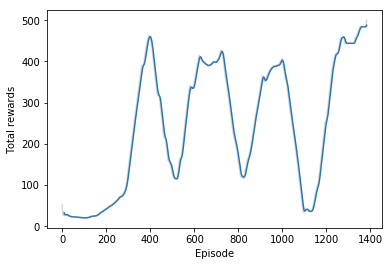

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

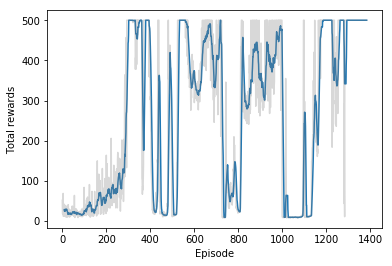

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

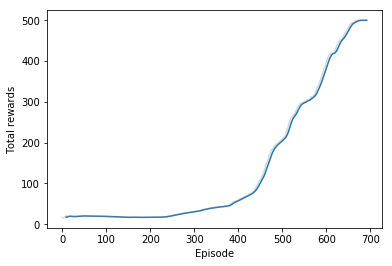

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

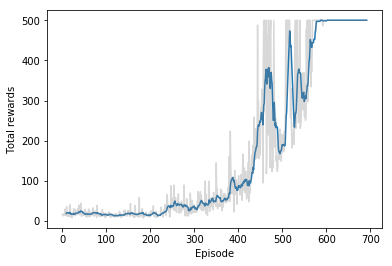

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

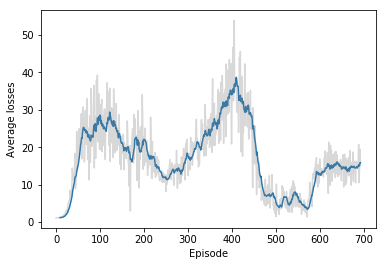

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

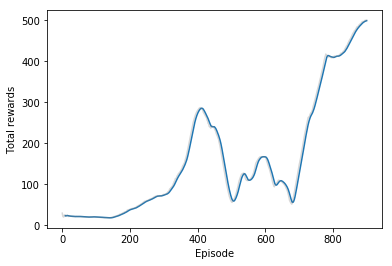

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

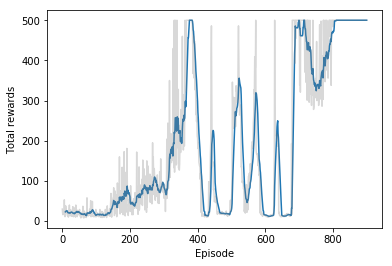

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

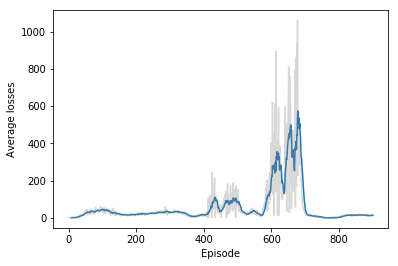

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.